***
# **Human Face Recognition**
***

## Problem Description

- We have a dataset containing a set of face images and need to perform Face Recognition, i.e. classifying the image whether it is a human face or not. 

- The dataset for this task is presented with images that has been pre-processed by an edge detection algorithm. The task is to determine whether the edge image is a face or not.

- So, each pixel in the image is classified to either edge (#) or no edge ( ). These pixel values are represented in the dataset with the two integers (0) for no edge and (2) for an edge.

- For instance, the first face in the training dataset will look like as follows:

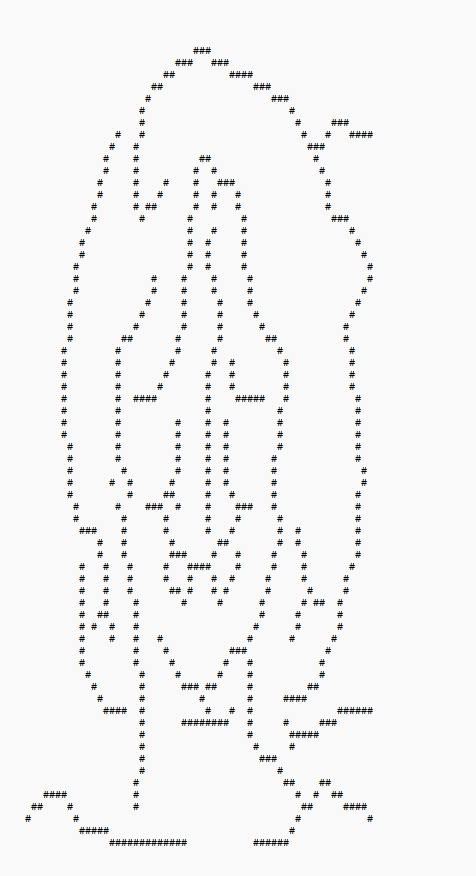

- Finally, our task is a binary classification one in which we need to classify each image to either non-face image (0), or a face image (1).

### Datum Encoding

To ease the manipulation of each face image, it will be encoded to a *Datum* object.

A datum is a pixel-level encoding method that will be used to represent digit images in an accessible manner.

Each face/non-face image is 60x74-pixels image.
Each pixel can take one of the following values:

-  0: No edge   ( )
-  2: Edge      (#)
  
Pixel data is stored in a 2-dimensional array (pixels), which maps to the original image pixels on a plane with standard euclidean axes .
The first array dimension representing the horizontal axes and the second dimension denoting the vertical axes.
      
The contents of the representation can be accessed directly via the *getPixel()* and *getPixels()* methods.

## 1. Dataset Loading

Calling the `getPixels()` method on each datum object will return a `[60][70]` 2-d list.
This 2-d list is flattened to a `[4200]` 1-d list using these functions *`loadFacesTrainDataset()`*, *`loadFacesValidDataset()`* and *`loadFacesTestDataset()`*.

In [1]:
from samples import *
def loadFacesTrainDataset(n):
  items = [ sum(datum.getPixels(), []) for datum in loadDataFile("data/facedata/facedatatrain", n,60,70) ]
  labels = loadLabelsFile("data/facedata/facedatatrainlabels", n)
  return np.array(items), np.array(labels)

def loadFacesValidDataset(n):
  items = [ sum(datum.getPixels(), []) for datum in loadDataFile("data/facedata/facedatavalidation", n,60,70) ]
  labels = loadLabelsFile("data/facedata/facedatavalidationlabels", n)
  return np.array(items), np.array(labels)

def loadFacesTestDataset(n):
  items = [ sum(datum.getPixels(), []) for datum in loadDataFile("data/facedata/facedatatest", n,60,70) ]
  labels = loadLabelsFile("data/facedata/facedatatestlabels", n)
  return np.array(items), np.array(labels)

Loading original datasets with total number of features = **4200**

In [2]:
import numpy as np
data_train, labels_train = loadFacesTrainDataset(5000)
data_valid, labels_valid = loadFacesValidDataset(1000)
data_test, labels_test = loadFacesTestDataset(1000)
data = np.concatenate((data_train, data_valid, data_test))
labels = np.concatenate((labels_train, labels_valid, labels_test))
print('Initial shape of face datasets (before feature reduction): ')
print('data_train: ' + str(data_train.shape) + ', labels_train: ' + str(labels_train.shape))
print('data_valid: ' + str(data_valid.shape) + ', labels_valid: ' + str(labels_valid.shape))
print('data_test:  ' + str(data_test.shape)  + ', labels_test:  ' + str(labels_test.shape))
print('data:       ' + str(data.shape) +       ', labels:       ' + str(labels.shape))

Initial shape of face datasets (before feature reduction): 
data_train: (451, 4200), labels_train: (451,)
data_valid: (301, 4200), labels_valid: (301,)
data_test:  (150, 4200), labels_test:  (150,)
data:       (902, 4200), labels:       (902,)


## 2. KNN Model

### 2.1. PCA Dimensionality Reduction


We now have our dataset with each record represented with an array of **4200** features, which is a huge number to deal with.

So, we will use **PCA Dimensionality Reduction** techniques to reduce the **4200** features down to a smaller (yet informative) set of features.

This is imporatnt to **enhance the accuracy of the trained models** due to the use of only informative and useful features.

We used the *`PCA()`* class from the *`scikit-learn`* library. To use this class, we pass only one argument *`n_components`* which is the no of  features to keep after performing reduction.

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)

pca.fit(data)

reduced_data = pca.transform(data)
# print(reduced_data.shape)

### 2.2. Determining optimum no of PCA components

Instead of selecting a random value for *`n_components`*, we determined its optimum value by trial.

This was done by assigning different values in the range of **[10, 100]** for the parameter *`n_compoenents`*.
A PCA transform is performed with each *`n_compoenents`* and then train and test a KNN model on these new reduced datasets.

This process is implemented as a *`Pipeline`*, where the first step performs the PCA transform, and the second step fits the KNN model to the datasets.


In [4]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

# Return a set of PCA-KNN pipeline models each with different n_components value
def get_pca_models(start, end, steps, pipeline_model):
    models = dict()
    for i in range (start, end, steps):
        steps = [ ('pca', PCA(n_components=i)), ('m', pipeline_model) ]
        models[str(i)] = Pipeline(steps=steps)
    return models

Hence, each pipeline will be evaluated using **Repeated Stratified Cross-Validation (RSCV)** with 3 repeats and 10 folds per repeat. 

Performance of each pipeline is presented as the **mean classification accuracy**.

In [5]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

# Apply Repeated Stratified Cross-Validation (RSCV) with 3 repeats and 10 folds per repeat
# Then return the accuracy scores for the given model
def evaluate_pca_model(model, data, labels):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, data, labels, cv=cv, scoring='accuracy', n_jobs=-1)
    return scores*100

Finally, we will have the model accuracy for each *`n_compoenents`* value represented in a boxplot to determine the optimum no of features

In [6]:
from numpy import mean, std
import matplotlib.pyplot as plt

# Evaluate the accuracy of all the passed models and display a boxplot of these accuracies
# Returns the optimimum no of PCA components that gives highest accuracy
def evaluate_pca_models(models):
    acc_scores, values = [], []
    max_acc_score = 0
    opt_n_components = 0
    print('n_components    Accuracy (mean)      Accuracy (std)')
    for n_components, model in models.items():
        acc_score = evaluate_pca_model(model, data, labels) # Returns a list of accuracy scores got from the cross-validation procedure
        acc_scores.append(acc_score)
        values.append(n_components)
        if(mean(acc_score) > max_acc_score):
            max_acc_score = mean(acc_score)
            opt_n_components = int(n_components)
        print('    %s             %.3f %%             %.3f' % (n_components, mean(acc_score), std(acc_score)))
    # plot the collected results on a box plot
    plt.boxplot(acc_scores, labels=values, showmeans=True)
    plt.xticks(rotation=45)
    plt.show()
    return opt_n_components, max_acc_score


Trying PCA transform with no of components in the range [10, 100]

n_components    Accuracy (mean)      Accuracy (std)
    10             86.179 %             3.422
    20             83.705 %             2.247
    30             76.755 %             4.165
    40             69.180 %             3.736
    50             64.525 %             2.985
    60             61.641 %             2.859
    70             59.685 %             2.856
    80             58.313 %             2.195
    90             58.389 %             1.584
    100             57.208 %             2.139


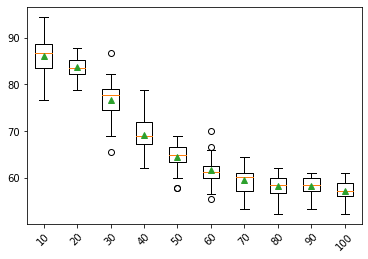

Initial no of components for KNN model: 10, with accuracy 86.179




In [7]:
# Create pca models with n_components 10, 20, 30, ..., 100
pca_knn_models = get_pca_models(10, 101, 10, KNeighborsClassifier())                                        

opt_n_components_knn, max_acc = evaluate_pca_models(pca_knn_models)

print('Initial no of components for KNN model: %d, with accuracy %.3f\n\n' % (opt_n_components_knn, max_acc))

Trying PCA transform again with narrower range for no of components, to get the exact optimum value

n_components    Accuracy (mean)      Accuracy (std)
    5             83.222 %             4.051
    6             83.698 %             4.114
    7             83.112 %             3.881
    8             85.032 %             3.547
    9             85.994 %             3.115
    10             85.993 %             3.827
    11             85.847 %             3.731
    12             86.991 %             3.716
    13             86.327 %             3.400
    14             86.256 %             2.629
    15             84.922 %             2.713


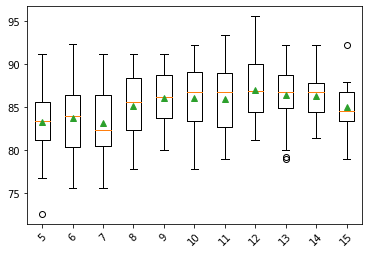

Best no of components for KNN model: 12, with accuracy 86.991




In [8]:

# Repeat the process with narrower range to get the precise n_components
pca_knn_models = get_pca_models(opt_n_components_knn-5, opt_n_components_knn+6, 1, KNeighborsClassifier())

opt_n_components_knn, max_acc = evaluate_pca_models(pca_knn_models)

print('Best no of components for KNN model: %d, with accuracy %.3f\n\n' % (opt_n_components_knn, max_acc))


### 2.3. Apply PCA with optimum no. of components

Perform PCA on dataset with calculated optimum no of components

In [9]:
# Applying PCA on the three dataset splits (train, valid, test) with calculated optimum no of components
from sklearn.decomposition import PCA

pca = PCA(n_components=opt_n_components_knn)
pca.fit(data)

data_train_knn = pca.transform(data_train)
data_valid_knn = pca.transform(data_valid)
data_test_knn = pca.transform(data_test)
data_knn = pca.transform(data)
print('data_train: ' + str(data_train_knn.shape) + ', labels_train: ' + str(labels_train.shape))
print('data_valid: ' + str(data_valid_knn.shape) + ', labels_valid: ' + str(labels_valid.shape))
print('data_valid: ' + str(data_test_knn.shape)  + ', labels_valid: ' + str(labels_test.shape))
print('data:       ' + str(data_knn.shape)       + ', labels:       ' + str(labels.shape))

data_train: (451, 12), labels_train: (451,)
data_valid: (301, 12), labels_valid: (301,)
data_valid: (150, 12), labels_valid: (150,)
data:       (902, 12), labels:       (902,)


### 2.4. Tuning KNN Model Hyperparameters

***
**There are two main hyperparameters in the KNN model, *`K`* and  *`distance metric`*, which can be manipulated to enhance the model accuracy**
***

- ***`K:`***


The best value for K can be found by algorithm tuning. And because we have an even number of classes (**10 classes: [0-9]**), we will choose a K value with an odd number to avoid a tie.

**So, we will try many different odd values for K (from 3 to 201)**

- ***`Distance Metric:`***

In our implementation, we will use *`Euclidean Distance`*, ***Manhattan Distance***, ***Cosine Distance*** to discover which of them are most suitable for out digit dataset.

- Euclidean Distance:

![Euclidean Distance Rule](https://www.kdnuggets.com/wp-content/uploads/popular-knn-metrics-5.jpg)

- Manhattan Distance:

![Manhattan Distance Rule](https://www.kdnuggets.com/wp-content/uploads/popular-knn-metrics-3.jpg)

- Cosine Distance:

![Cosine Distance Rule](https://www.kdnuggets.com/wp-content/uploads/popular-knn-metrics-6.png)


We will experiment with different distance metrics and different values of K together and see which mix results in the most accurate model.

This will be done by using the *`KNeighborsClassifier()`* class from the *`scikit-learn`* library. 

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


# Create a knn model with specified K and distance metric
# Fit the knn model with training dataset (X, y), then test it with X_test
# Returns the accuracy score after testing the model
def knn_test(X, y, X_test, y_test, K, metric):
    knn = KNeighborsClassifier(n_neighbors=K, metric=metric, n_jobs=-1)
    knn.fit(X, y)
    y_pred = knn.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    # print('Metric: %s,      K: %d,      accuracy: %.6f' % (metric, K, acc_score))
    return acc_score*100


In [11]:
# Create knn models with the given metric and k values within the given range
# Plot each of the models against its accuracy score (to find the best K value) 
def knn_explore_K_metric_comb(metric: str, k_values: list):
    print('(%s Distance Method) with (K values [3-200])' % (metric.upper()))
    print('----------------------------------------------------------------')
    acc_scores = []
    k_opt = 0
    max_acc_score = 0
    for k in k_values:
        acc_score = knn_test(data_train, labels_train, data_valid, labels_valid, k, metric)
        acc_scores.append(acc_score)
        if (acc_score > max_acc_score):
            max_acc_score = acc_score
            k_opt = k
    plt.plot(k_values, acc_scores, 'b--')
    plt.title(metric.upper() + ' Distance with K values [3 - 200]')
    plt.xlabel('K (No of Neighbors)')
    plt.ylabel('Model Accuracy (%)')
    plt.show()
    print('Best K value for %s distance is %d , with accuracy %.3f %%' % (str(metric), k_opt, max_acc_score))
    ('----------------------------------------------------------------')
    return acc_scores

**Explore the KNN models accuracies with K values **([3,200])** with the three metrics **(euclidean, manhattan, cosine)****

(EUCLIDEAN Distance Method) with (K values [3-200])
----------------------------------------------------------------


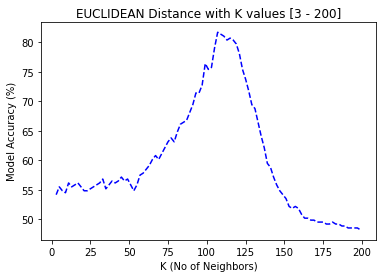

Best K value for euclidean distance is 107 , with accuracy 81.728 %
(CITYBLOCK Distance Method) with (K values [3-200])
----------------------------------------------------------------


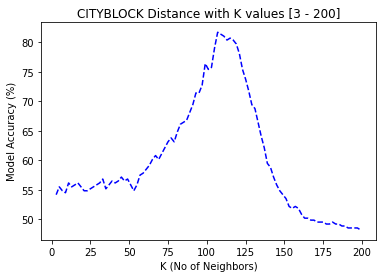

Best K value for cityblock distance is 107 , with accuracy 81.728 %
(COSINE Distance Method) with (K values [3-200])
----------------------------------------------------------------


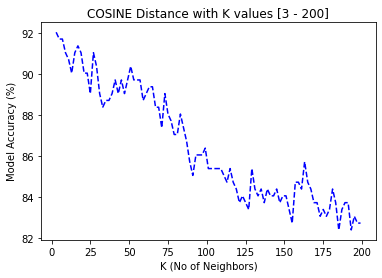

Best K value for cosine distance is 3 , with accuracy 92.027 %


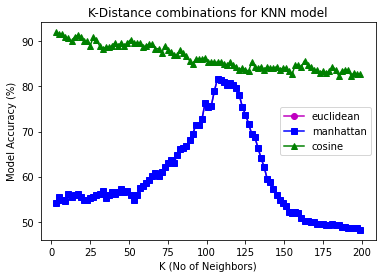

In [12]:
# Explore the three distance methods 'euclidean', 'manhattan', and 'cosine'
# Combinations of each method with K values in range [3- 200] are explored and plotted together

k_values = list(range(3, 200, 2)) 
metrics = ['euclidean', 'cityblock', 'cosine'] # cityblock = manhattan
acc_scores = {}
for metric in metrics:
    acc_scores[metric] = knn_explore_K_metric_comb(metric, k_values)

plt.plot(k_values, acc_scores['euclidean'], 'o-m', label='euclidean')
plt.plot(k_values, acc_scores['cityblock'], 's-b', label='manhattan')
plt.plot(k_values, acc_scores['cosine'], '^-g', label='cosine')
plt.legend()
plt.title('K-Distance combinations for KNN model')
plt.xlabel('K (No of Neighbors)')
plt.ylabel('Model Accuracy (%)')
plt.show()




***
**Best `K value` = 3**

**Best `distance metric` = *cosine***

**Best `Model Accuracy` = 92.027 %**

***

### 2.5 Training and Testing KNN Model with optimal hyperparameters

The KNN model will be trained with the *`facedatatrain`* dataset, and tested against the *`facedatatest`* dataset

In [13]:
from sklearn.neighbors import KNeighborsClassifier

K = 3
METRIC = 'cosine'
knn = KNeighborsClassifier(n_neighbors=K, metric=METRIC, n_jobs=-1)
knn.fit(data_train, labels_train)
labels_pred_knn = knn.predict(data_test)
acc_score_knn = accuracy_score(labels_test, labels_pred_knn)*100
print('Metric: %s,      K: %d,      Accuracy: %.3f %%' % (METRIC, K, acc_score_knn))

Metric: cosine,      K: 3,      Accuracy: 92.667 %


***
**KNN Model accuracy is 92.667 %**
***

.

.

## 3. Gaussian Naive-Bayes Model

### 3.1. PCA Dimensionality Reduction

We will need to perform PCA transform again because the optimum no of PCA components for the KNN model is not necessarily the same for the Naive Bayes model.

### 3.2. Determining optimum no of PCA components

Trying PCA transform in the same way we did before using the `*get_pca_models()*` and `evaluate_pca_models()` functions with no of components in the range **[10, 100]**

n_components    Accuracy (mean)      Accuracy (std)
    10             79.632 %             4.173
    20             86.696 %             3.652
    30             87.438 %             2.969
    40             88.473 %             2.828
    50             88.103 %             2.919
    60             84.585 %             4.511
    70             76.418 %             5.466
    80             69.693 %             4.862
    90             62.670 %             3.664
    100             59.753 %             3.325


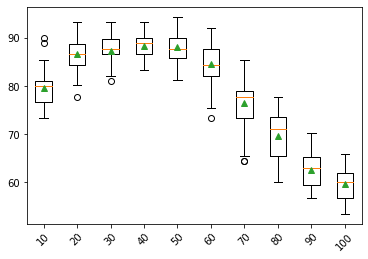

----------------------------------------------------------------
Initial no of components for Naive Bayes model: 40, with accuracy 88.473




In [14]:
from sklearn.naive_bayes import GaussianNB

# Create pca models with n_components 10, 20, 30, ..., 100
pca_bayes_models = get_pca_models(10, 101, 10, GaussianNB())                                         ###########################################
opt_n_components_bayes, max_acc = evaluate_pca_models(pca_bayes_models)
print('----------------------------------------------------------------')
print('Initial no of components for Naive Bayes model: %d, with accuracy %.3f\n\n' % (opt_n_components_bayes, max_acc))


Trying PCA transfrom again with narrower range for no of components, to get the optimum value

n_components    Accuracy (mean)      Accuracy (std)
    35             87.884 %             3.561
    36             87.143 %             2.926
    37             87.772 %             3.038
    38             87.957 %             3.228
    39             87.588 %             3.110
    40             87.884 %             3.518
    41             87.955 %             2.774
    42             88.547 %             2.811
    43             88.731 %             3.672
    44             88.586 %             3.133
    45             88.696 %             2.672


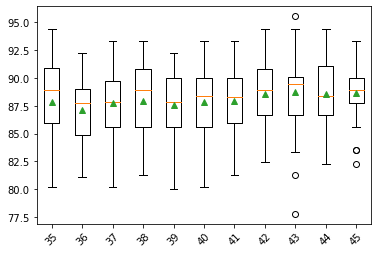

----------------------------------------------------------------
Best no of components for Naive Bayes model: 43, with accuracy 88.731




In [15]:

# Repeat the process with narrower range to get the precise n_components
pca_bayes_models = get_pca_models(opt_n_components_bayes-5, opt_n_components_bayes+6, 1, GaussianNB())    ############################################
opt_n_components_bayes, max_acc = evaluate_pca_models(pca_bayes_models)
print('----------------------------------------------------------------')
print('Best no of components for Naive Bayes model: %d, with accuracy %.3f\n\n' % (opt_n_components_bayes, max_acc))


### 3.3. Applying PCA Feature Reduction

In [16]:
# Applying PCA on the three dataset splits (train, valid, test) with optimum no of components
from sklearn.decomposition import PCA

pca = PCA(n_components=opt_n_components_bayes)
pca.fit(data)

data_train_bayes = pca.transform(data_train)
data_valid_bayes = pca.transform(data_valid)
data_test_bayes = pca.transform(data_test)
data_bayes = pca.transform(data)

print('data_train: ' + str(data_train_bayes.shape) + ', labels_train: ' + str(labels_train.shape))
print('data_valid: ' + str(data_valid_bayes.shape) + ', labels_valid: ' + str(labels_valid.shape))
print('data_valid: ' + str(data_test_bayes.shape)  + ', labels_valid: ' + str(labels_test.shape))
print('data        ' + str(data_bayes.shape)       + ', labels:       ' + str(labels.shape))


data_train: (451, 43), labels_train: (451,)
data_valid: (301, 43), labels_valid: (301,)
data_valid: (150, 43), labels_valid: (150,)
data        (902, 43), labels:       (902,)


### 3.4. Training and Testing a Naive-Bayes Model

Training a naive Bayes model is easy and fast because there are no hyperparameters to set.

So, we will direcly create a model using the class `*GaussianNB()*` from the `*scikit-learn*` library


In [17]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()
naive_bayes.fit(data_train, labels_train)
labels_pred_bayes = naive_bayes.predict(data_test)
acc_score_bayes = accuracy_score(labels_test, labels_pred_bayes)*100
print('Naive-Bayes Model Accuracy: %.3f %%' % (acc_score_bayes))




Naive-Bayes Model Accuracy: 88.000 %


***
**Naive-Bayes Model accuracy is 88.000 %**
***

.

.

# 4. Decision Trees

For depth = 1
Accuracy = 54.67 %
For depth = 21
Accuracy = 66.00 %
For depth = 41
Accuracy = 66.00 %
For depth = 61
Accuracy = 66.00 %
For depth = 81
Accuracy = 66.00 %
For depth = 101
Accuracy = 66.00 %
For depth = 121
Accuracy = 66.00 %
For depth = 141
Accuracy = 66.00 %
For depth = 161
Accuracy = 66.00 %
For depth = 181
Accuracy = 66.00 %
For depth = 201
Accuracy = 66.00 %
-------------------------------
Best max depth = 201
with accuracy = 66.00 %


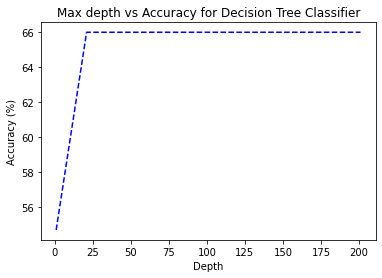

'Best decision tree.pdf'

In [18]:
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn import tree
from samples import *
import matplotlib.pyplot as plt

max_depth = 0
best_decision_tree = None
depths, accs = [], []
for depth in range(1, 202, 20):
    decision_tree = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=depth)
    decision_tree = decision_tree.fit(data_train, labels_train)
    print("For depth = " + str(depth))
    acc = decision_tree.score(data_test, labels_test)*100
    print("Accuracy = %.2f %%" % (acc))
    if max_depth < depth:
        max_depth = depth
        best_decision_tree = decision_tree
    depths.append(depth)
    accs.append(acc)

print('-------------------------------')
print("Best max depth = " + str(max_depth))
print("with accuracy = %.2f %%" % (best_decision_tree.score(data_test, labels_test)*100))

plt.plot(depths, accs, 'b--')
plt.title( 'Max depth vs Accuracy for Decision Tree Classifier')
plt.xlabel('Depth')
plt.ylabel('Accuracy (%)')
plt.show()

dot_data = tree.export_graphviz(best_decision_tree,
                                out_file=None,
                                filled=True,
                                rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("Best decision tree")


# 5. SVM (Support Vector Machine)

In [19]:
from sklearn import svm
from samples import *

# values for kernel hyperparameter
kernels = ['linear', 'rbf', 'sigmoid']

for kernel in kernels:
    clf = svm.SVC(kernel=kernel)
    clf.fit(data_train, labels_train)
    print("Kernel: " + kernel)
    print('Accuracy: %.2f ' % (clf.score(data_test, labels_test)*100) )
    print()


Kernel: linear
Accuracy: 90.00 

Kernel: rbf
Accuracy: 90.00 

Kernel: sigmoid
Accuracy: 89.33 



# 6. MLP (Multi-layer Perceptron)

In [20]:
from sklearn.neural_network import MLPClassifier
from samples import *

max = 0
x = ""
activation_functions = ["identity", "logistic", "tanh", "relu"]
for act in activation_functions:
    for hdn in range(1, 302, 20):
        for epochs in range(200, 501, 20):
            clf = MLPClassifier(hidden_layer_sizes=hdn, random_state=0, max_iter=epochs, activation=act).fit(data_train, labels_train)
            if max < clf.score(data_test, labels_test):
                x = "hidden layers=" + str(hdn) + ", number of epochs = " + str(
                    epochs) + ", activation function is " + str(act)
                max = clf.score(data_test, labels_test)

print("the best accuracy is " + str(max*100) + " % ")
print("with these hyperparameters: " + x)

c:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
